# Building convolutional neural networks in Tensorflow and Keras

# Convolutional neural networks
  
Text.

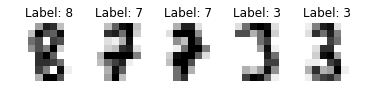

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

%matplotlib inline

np.random.seed(0)

digits = datasets.load_digits()
    
mnist_data = digits.images
mnist_data = mnist_data[:,:,:,np.newaxis]
labels = digits.target

# choose some random images to display
indices = np.arange(len(digits.images))
display = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[display]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[display[i]])
plt.show()


In [2]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

labels = to_categorical(labels)

train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(mnist_data, labels, train_size=train_size,
                                                    test_size=test_size)


Using TensorFlow backend.


In [3]:
import tensorflow as tf

class CNNModel:
    def __init__(
        self,
        input_shape,
        n_filters=10,
        n_neurons_connected=50,
        n_categories=10,
        receptive_field=3,
        stride=1,
        padding=1,
        eta=0.1,
    ):
        
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

        self.input_width, self.input_height, self.depth = input_shape
        
        self.n_filters = n_filters
        self.n_downsampled = int(self.input_width*self.input_height*n_filters / 4)
        self.n_neurons_connected = n_neurons_connected
        self.n_categories = n_categories
        
        self.receptive_field = receptive_field
        self.stride = stride
        self.strides = [stride, stride, stride, stride]
        self.padding = padding
        self.eta = eta
        
        self.create_placeholders()
        self.create_CNN()
        self.create_loss()
        self.create_accuracy()
        self.create_optimiser()
    
    def create_placeholders(self):
        with tf.name_scope('data'):
            self.X = tf.placeholder(tf.float32, shape=(None, self.input_width, self.input_height, self.depth), name='X_data')
            self.Y = tf.placeholder(tf.float32, shape=(None, self.n_categories), name='Y_data')
    
    def create_CNN(self):
        with tf.name_scope('CNN'):
            
            # Convolutional layer
            W_conv = self.weight_variable([self.receptive_field, self.receptive_field, self.depth, self.n_filters], name='conv', dtype=tf.float32)
            b_conv = self.weight_variable([self.n_filters], name='conv', dtype=tf.float32)
            z_conv = tf.nn.conv2d(self.X, W_conv, self.strides, padding='SAME', name='conv') + b_conv
            a_conv = tf.nn.relu(z_conv)
            
            # 2x2 max pooling
            a_pool = tf.nn.max_pool(a_conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME', name='pool')
            
            # Fully connected layer
            a_pool_flat = tf.reshape(a_pool, [-1, self.n_downsampled])
            W_fc = self.weight_variable([self.n_downsampled, self.n_neurons_connected], name='fc', dtype=tf.float32)
            b_fc = self.bias_variable([self.n_neurons_connected], name='fc', dtype=tf.float32)
            a_fc = tf.nn.relu(tf.matmul(a_pool_flat, W_fc) + b_fc)
            
            # Output layer
            W_out = self.weight_variable([self.n_neurons_connected, self.n_categories], name='out', dtype=tf.float32)
            b_out = self.bias_variable([self.n_categories], name='out', dtype=tf.float32)
            self.z_out = tf.matmul(a_fc, W_out) + b_out
    
    def create_loss(self):
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.Y, logits=self.z_out))

    def create_accuracy(self):
        with tf.name_scope('accuracy'):
            correct_prediction = tf.equal(tf.argmax(self.Y, 1), tf.argmax(self.z_out, 1))
            correct_prediction = tf.cast(correct_prediction, tf.float32)
            self.accuracy = tf.reduce_mean(correct_prediction)
    
    def create_optimiser(self):
        with tf.name_scope('optimizer'):
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.eta).minimize(self.loss, global_step=self.global_step)
            
    def weight_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name, dtype=dtype)
    
    def bias_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name, dtype=dtype)

In [4]:
from sklearn.metrics import accuracy_score

epochs = 10
batch_size = 100
n_inputs = X_train.shape[0]
input_shape = X_train.shape[1:]
n_filters=10
n_neurons_connected=50
n_categories=10

eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)


In [5]:
CNN = CNNModel(input_shape)

iterations = n_inputs // batch_size
data_indices = np.arange(n_inputs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        for j in range(iterations):
            chosen_datapoints = np.random.choice(data_indices, size=batch_size, replace=False)
            batch_X, batch_Y = X_train[chosen_datapoints], Y_train[chosen_datapoints]
            
            sess.run([CNN.loss, CNN.optimizer],
                     feed_dict={CNN.X: batch_X,
                                CNN.Y: batch_Y})
            accuracy = sess.run(CNN.accuracy,
                                feed_dict={CNN.X: batch_X,
                                           CNN.Y: batch_Y})
            step = sess.run(CNN.global_step)
    
    train_loss, train_accuracy = sess.run([CNN.loss, CNN.accuracy],
                                          feed_dict={CNN.X: X_train,
                                                     CNN.Y: Y_train})
    
    test_loss, test_accuracy = sess.run([CNN.loss, CNN.accuracy],
                                        feed_dict={CNN.X: X_test,
                                                   CNN.Y: Y_test})
    
    print("Train accuracy: %.3f" % train_accuracy)
    print("Test accuracy: %.3f" % test_accuracy)

Train accuracy: 0.974
Test accuracy: 0.956


In [6]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

def create_CNN(input_shape, n_filters, receptive_field, n_neurons_connected, n_categories):
    model = Sequential()
    model.add(Conv2D(n_filters, (receptive_field, receptive_field), input_shape=input_shape, padding='same',
              activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(n_neurons_connected, activation='relu'))
    model.add(Dense(n_categories, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    
    return model

model = create_CNN(input_shape, n_filters, 3, n_neurons_connected, n_categories)
model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)

scores = model.evaluate(X_test, Y_test)
print("Accuracy: %.3f" % scores[1])

360/360 [==============================] - 0s 74us/step
Accuracy: 0.850
